In [23]:
# Generales
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer  # Stopwords
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

# Tensorflow y Keras
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
def get_dictionary(text, sw, N):
    vectorizer = CountVectorizer(stop_words=sw, max_features=N)
    vectorizer.fit_transform(text)
    dictionary = vectorizer.vocabulary_
    dictionary = {word: i + 2 for i, word in enumerate(vectorizer.get_feature_names_out())}
    dictionary['DESC'] = 0
    dictionary['PAD'] = 1
    return dictionary

In [25]:
def sanitize_tweet(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

In [26]:
texto = "Hola @usuario, visita http://example.com para más info! ;) #feliz #día"
print(sanitize_tweet(texto))

hola  visita  para ms info


In [27]:
def text_to_sequence(text, dictionary, stop_words, T):
    palabras = re.findall(r'\b\w+\b', text.lower())  # Tokenizar correctamente
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    secuencia = [dictionary.get(palabra, dictionary['DESC']) for palabra in palabras]
    secuencia = secuencia[:T]
    secuencia += [dictionary['PAD']] * (T - len(secuencia))
    return np.array(secuencia)

In [28]:
# Parámetros configurables
N = 20000  # Número de palabras del diccionario
T = 100    # Longitud prefijada de la reseña
D = 128  # Dimensión del embedding
EPOCHS = 20
NEURONAS = 128

# Usamos la lista de stopwords de sklearn
stop_words = list(ENGLISH_STOP_WORDS)

path = "/kaggle/input/tweetsdata/tuits_desastres.csv"

datos = pd.read_csv(path)

In [29]:
datos.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [30]:
datos.drop(["id", "keyword", "location"], axis=1, inplace=True)

In [31]:
datos.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
# Unimos las preguntas
datos['text'] = datos['text'].apply(sanitize_tweet)

# Textos de entrada
textos = datos["text"].astype(str).tolist()  # Aseguramos que todo es string

# Parámetros
max_tokens = N        # Número máximo de palabras en el vocabulario
output_sequence_length = T  # Longitud fija de la secuencia
stop_words = set(stop_words)  # Asegúrate que sea un set para que puedas usarlo luego si lo necesitas

# Capa TextVectorization
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
)

# Adaptamos al texto
vectorize_layer.adapt(textos)

# Aplicamos la vectorización
X = vectorize_layer(tf.constant(textos))

# Si necesitas como NumPy array
X = X.numpy()
y = datos['target'].values

In [33]:
datos.head(50)

,text,target
0,our deeds are the reason of this may allah fo...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive evacuation orders in cal...,1
4,just got sent this photo from ruby as smoke f...,1
5,update california hwy 20 closed in both direc...,1
6,heavy rain causes flash flooding of streets in...,1
7,im on top of the hill and i can see a fire in ...,1
8,theres an emergency evacuation happening now i...,1
9,im afraid that the tornado is coming to our area,1


In [34]:
X.shape

(7613, 100)

In [35]:
X.shape[1]

100

In [36]:
print(X.shape)
print(y.shape)

(7613, 100)
(7613,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [85]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ReduceLROnPlateau 

earlystopping = EarlyStopping( 
    monitor='val_loss',  # Métrica a controlar 
    min_delta=0.001,     
    patience=5,         
    mode='min',          
    restore_best_weights=True # Restaurar los mejores pesos 
) 

lrScheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) 

In [149]:
model = Sequential([
    Input(shape=(T,)),
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=64)),    
    #Bidirectional(LSTM(units=64)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)             │ (None, 100, 128)            │       2,560,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_28 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,659,201 (10.14 MB)

 Trainable params: 2,659,201 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [150]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, verbose=1, callbacks=[earlystopping, lrScheduler])

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5634 - loss: 0.6722 - val_accuracy: 0.7668 - val_loss: 0.5278 - learning_rate: 0.0010
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8100 - loss: 0.4518 - val_accuracy: 0.7997 - val_loss: 0.4621 - learning_rate: 0.0010
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8917 - loss: 0.2971 - val_accuracy: 0.7906 - val_loss: 0.4902 - learning_rate: 0.0010
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9401 - loss: 0.1819 - val_accuracy: 0.7833 - val_loss: 0.5599 - learning_rate: 0.0010
Epoch 5/30
37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9655 - loss: 0.1081
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9651 - loss: 0.1089 - val_accuracy: 0.7865 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9741 - loss: 0.0795 - val_accu

In [151]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

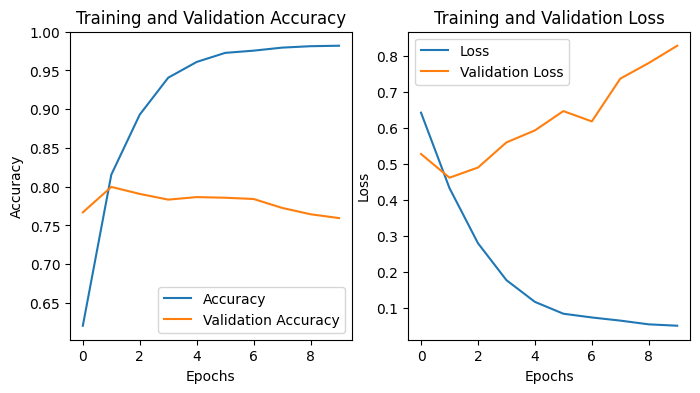

In [152]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Reporte de Clasificación:
               precision    recall  f1-score   support

No Catástrofe       0.80      0.82      0.81       893
   Catástrofe       0.74      0.70      0.72       630

     accuracy                           0.77      1523
    macro avg       0.77      0.76      0.76      1523
 weighted avg       0.77      0.77      0.77      1523



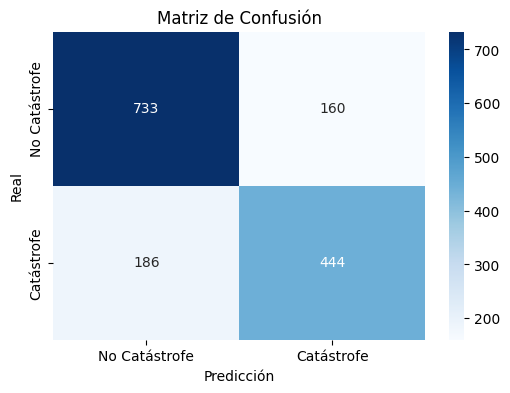

In [153]:
def train_validation(model, X_test, y_test):
   
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Catástrofe", "Catástrofe"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Catástrofe", "Catástrofe"],
                yticklabels=["No Catástrofe", "Catástrofe"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)